In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
def split_dataset(x, y, train_per, dev_per, test_per):
    """
        Splits dataset (i.e. x, y) into 3 parts, specified by their percentages
        Example: split_dataset(x, y, 80, 10, 10) will split x and y into the following:
        
        train: 80%
        dev: 10%
        test: 10%
        
        Note: x and y should be ndarray's of size: (M X N) where M is the no:of examples and N is some number
    """
    rows = x.shape[0]
    cols = x.shape[1]
    
    combined = np.hstack((x, y))
    np.random.shuffle(combined)
    
    x = combined[:,:cols]
    y = combined[:,cols:]
    
    train_size = int((train_per / 100) * rows)
    dev_size = int((dev_per / 100) * rows)
    test_size = int((test_per / 100) * rows)
    
    train_x = x[:train_size]
    dev_x = x[train_size:train_size + dev_size]
    test_x = x[train_size + dev_size:]
    
    train_y = y[:train_size]
    dev_y = y[train_size:train_size + dev_size]
    test_y = y[train_size + dev_size:]
    
    print("\nx: " + str(x.shape))
    print("y: " + str(y.shape))
    print("train_x: " + str(train_x.shape))
    print("train_y: " + str(train_y.shape))
    print("dev_x: " + str(dev_x.shape))
    print("dev_y: " + str(dev_y.shape))
    print("test_x: " + str(test_x.shape))
    print("test_y: " + str(test_y.shape) + "\n")
    
    return (train_x, dev_x, test_x, train_y, dev_y, test_y)

In [3]:
def de_normalize(mew, std, vec):
    """
        mew and std are numbers denoting the original mean and standard deviation of the vector.
        vec is of size (M X 1), i.e. it is a single feature vector
        
        Returns the denormalized vector
    """
    return ((vec * std) + mew) 

In [4]:
def normalize(vec):
    """
        vec is of size (M X 1), i.e. it is a single feature vector
        
        Returns a normalized vector
    """
    mew = np.average(vec)
    std = np.std(vec)
    return (mew, std, (vec - mew)/std)

In [5]:
def squared_error_cost(x, y, theta, lambd):
    """
        x is (M X (N + 1))
        y is (M X 1)
        theta is ((N + 1) X 1)
    """
    
    # calculate hypothesis
    h = x @ theta
    
    # calculate regularization term
    reg_term = np.sum(lambd * (theta[1:,:].reshape(theta.shape[0] - 1, 1) ** 2))
    
    # calculate cost and return it
    cost = (1/(2 * M)) * (np.sum((h - y) ** 2) + reg_term)
    return cost

In [6]:
def gradient_descent(alpha, lambd, x, y, theta, cost_func, num_iters, create_new_fig):
    """
        x is (M X (N + 1))
        y is (M X 1)
        theta is ((N + 1) X 1)
        
        create_new_fig : denotes whether to plot the graph on a new figure or not
        
        Runs gradient descent algorithm for num_iters times and returns the final theta and cost
        Also plots the way cost has varied over time
    """
    M = x.shape[0]
    cost_arr = []
    
    for i in range(num_iters):
        h = x @ theta
        reg_term = lambd * theta[1:]
        theta[0] = theta[0] - (alpha/M) * np.sum(h - y)
        theta[1:] = theta[1:] - (alpha/M) * (np.sum((h - y) * x[:,1:], axis=0, keepdims=True).T + reg_term)
        cost_arr.append(cost_func(x, y, theta, lambd))

    if(create_new_fig):
        fig = plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.title('lambda=' + str(lambd))

    plt.plot(cost_arr)
    return theta

In [7]:
def predict(x_val, y_val, theta, mew_x, std_x, mew_y, std_y, col_names, print_samples, num_samples):
    """
        Performs predictions, given input x, y and theta. Also returns the RMSE accuracy of the predictions
        
        In order to calculate the RMSE accuracy, the mean and standard deviations (of x's and y's) are required.
        
        It also has the ability to print few sample prediction results (for comparision purposes)
    """

    h_val = x_val @ theta
    
    x = np.zeros(shape=x_val.shape)
    y = np.zeros(shape=y_val.shape)
    
    # Denormalize
    for i in range(1, x.shape[1]):
        x[:,i] = de_normalize(mew_x[i - 1], std_x[i - 1], x_val[:,i])
    
    y = de_normalize(mew_y, std_y, y_val)
    h = de_normalize(mew_y, std_y, h_val)
    
    # Calculate the accuracy
    rmse_accuracy = np.sqrt(((h - y) ** 2).mean())
    
    if(print_samples):
        # Take few samples for prediction
        sample_x, sample_y, sample_h = sample(x, y, h, num_samples)
        print("Sample prediction results:\n")
        for i in range(sample_x.shape[0]):
            print("\n" + ("*" * 40))
            print("X value: ")
            for j in range(1, sample_x.shape[1]):
                print(str(sample_x[i][j]) + " " + col_names[j], end=" ")
            print("\nY value: " + str(sample_y[i][0]) + " " + col_names[0])
            print("Predicted value: " + str(sample_h[i][0]) + " " + col_names[0])
            print(("*" * 40) + "\n")

    
    return rmse_accuracy

In [8]:
def sample(a, b, c, num):
    """
        a and b and c are of size (M X N)
    
        Returns 'num' no:of samples randomly chosen from a and b
    """
    rand_index = np.arange(a.shape[0]).reshape(a.shape[0], 1)
    np.random.shuffle(rand_index)
    rand_index = rand_index[0:num]
    return a[rand_index].reshape(num, a.shape[1]), b[rand_index].reshape(num, b.shape[1]), c[rand_index].reshape(num, c.shape[1])

In [9]:
def pre_process_data(data):
    """
        Accepts a dataframe as input, performs pre-processing and returns (x, y, col_names)
        
        x (an ndarray) is the feature matrix of size (M X N) where M is the no:of examples and N is the no:of features
        y (an ndarray) contains actual results (of size (M X 1))
        col_names is a python list which contains the name of the columns present in y and x (of size ((N + 1) X 1))
        
        Note: The first element in col_names is the column name for y, the
        subsequent names are the names of features present in X
    """
    # Reorder the columns
    cols = data.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    data = data[cols]
    
    # Drop nan rows
    data = data.dropna()
    print("Shape of data after dropping NaN rows: " + str(data.shape))
    print("Sample dataset: \n")
    print(data.head())

    col_names = ['sound_pressure', 'hertz', 'angle', 'chord_length', 'velocity', 'thickness']
    data = data[col_names]

    # Convert the data into numpy array
    data = data.values

    # Extract input and output variables
    y = data[:,:1]
    x = data[:,1:]

    # Visualize them
    for i in range(x.shape[1]):
        feature = x[:,i].reshape(x.shape[0], 1)
        fig = plt.figure(figsize=(7, 6), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(feature, y, 'bo', markersize=5, label=col_names[i + 1])
        plt.legend(loc='upper left')
        plt.xlabel(col_names[i + 1])
        plt.ylabel(col_names[0])
    
    return (x, y, col_names)

In [10]:
def gradient_descent_optimize(train_x, dev_x, train_y, dev_y, cross_validation_times,
                              cost_func, alpha, num_iters, lambd):
    """
        Performs training on train_x and train_y using the cost_func() cost function
        
        Starts by randomly initializing the theta vector. Multiple random initializations
        are done, 'cross_validation_times' times, and a global optimal theta is returned
        along with the global_min_cost
        
        Each random initialization result is tested on dev_x and dev_y
    """

    N = train_x.shape[1]
    
    global_min_cost = sys.maxsize
    global_optimal_theta = np.empty((N, 1))

    # Loop which runs multiple times (Each time trying a new random initialization)
    for i in range(cross_validation_times):
        theta = np.random.rand(N, 1)
        optimal_theta = gradient_descent(alpha, lambd, train_x, train_y, theta, cost_func, num_iters, i==0)
        min_cost = cost_func(dev_x, dev_y, optimal_theta, lambd)
        if(min_cost < global_min_cost):
            global_min_cost = min_cost
            global_optimal_theta = optimal_theta
            
    return global_optimal_theta, global_min_cost

Shape of data read: (1503, 6)
Shape of data after dropping NaN rows: (1503, 6)
Sample dataset: 

   sound_pressure  hertz  angle  chord_length  velocity  thickness
0         126.201    800    0.0        0.3048      71.3   0.002663
1         125.201   1000    0.0        0.3048      71.3   0.002663
2         125.951   1250    0.0        0.3048      71.3   0.002663
3         127.591   1600    0.0        0.3048      71.3   0.002663
4         127.461   2000    0.0        0.3048      71.3   0.002663

x: (1503, 6)
y: (1503, 1)
train_x: (1052, 6)
train_y: (1052, 1)
dev_x: (300, 6)
dev_y: (300, 1)
test_x: (151, 6)
test_y: (151, 1)

Running gradient descent for lambda=0 ...
Running gradient descent for lambda=0.3 ...
Running gradient descent for lambda=1 ...
Running gradient descent for lambda=3 ...
Running gradient descent for lambda=10 ...

Network parameters:
alpha: 0.001
lambda: 1
num_iters: 6000
Optimal value of theta: 
[[-0.00137902]
 [-0.5499085 ]
 [-0.37372499]
 [-0.48185622]
 [ 0.204748

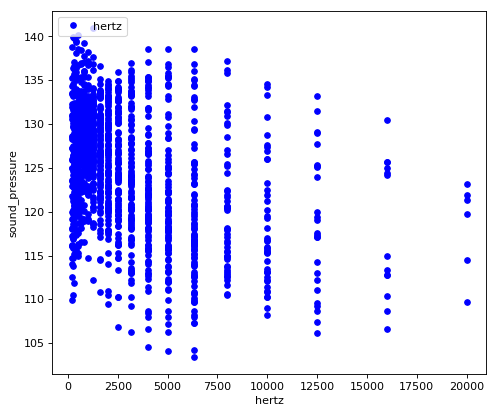

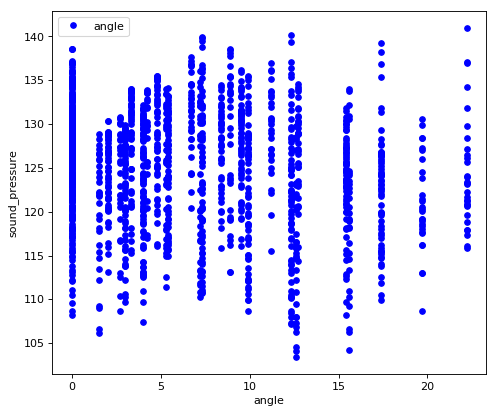

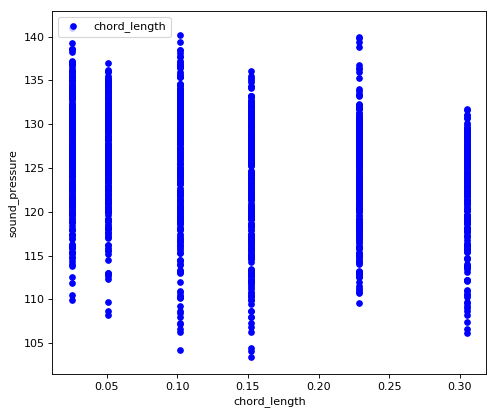

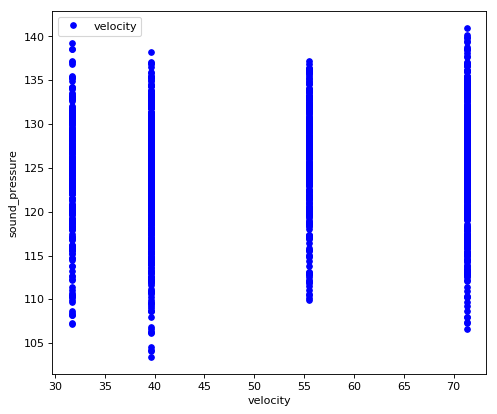

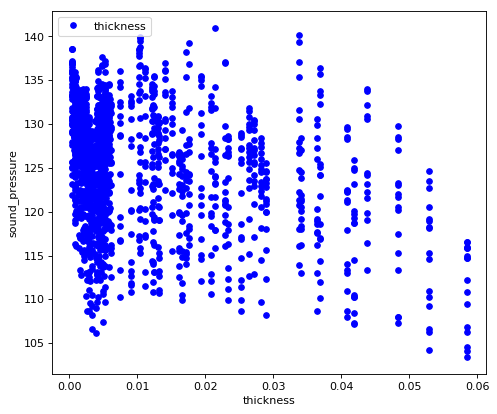

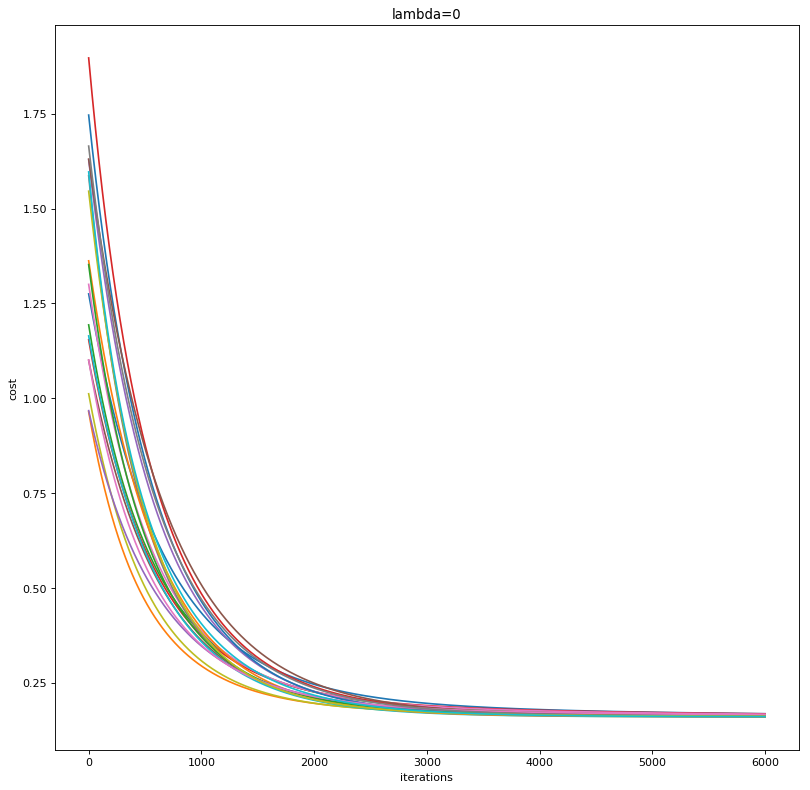

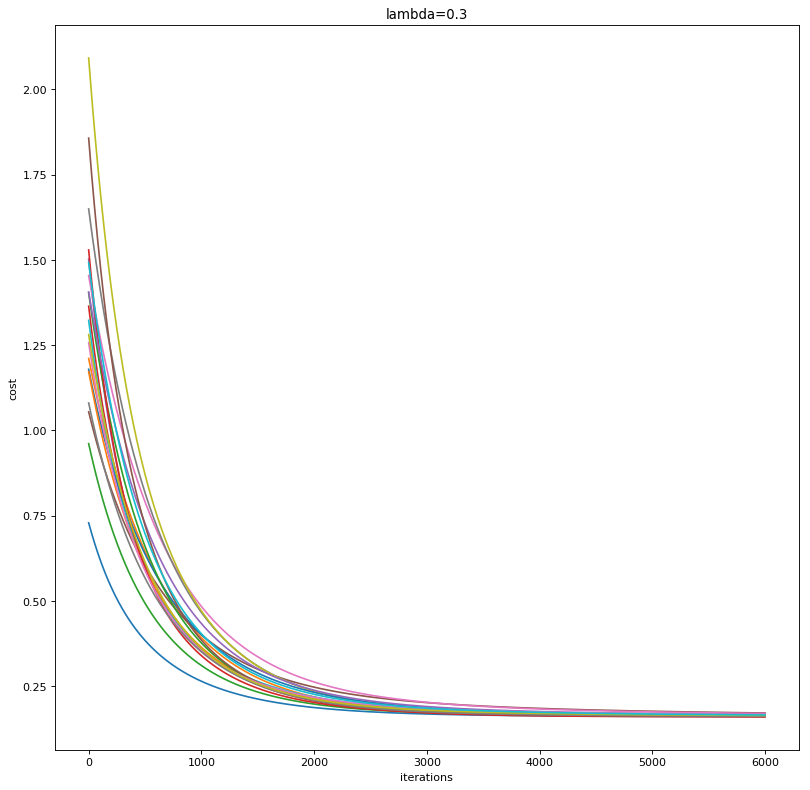

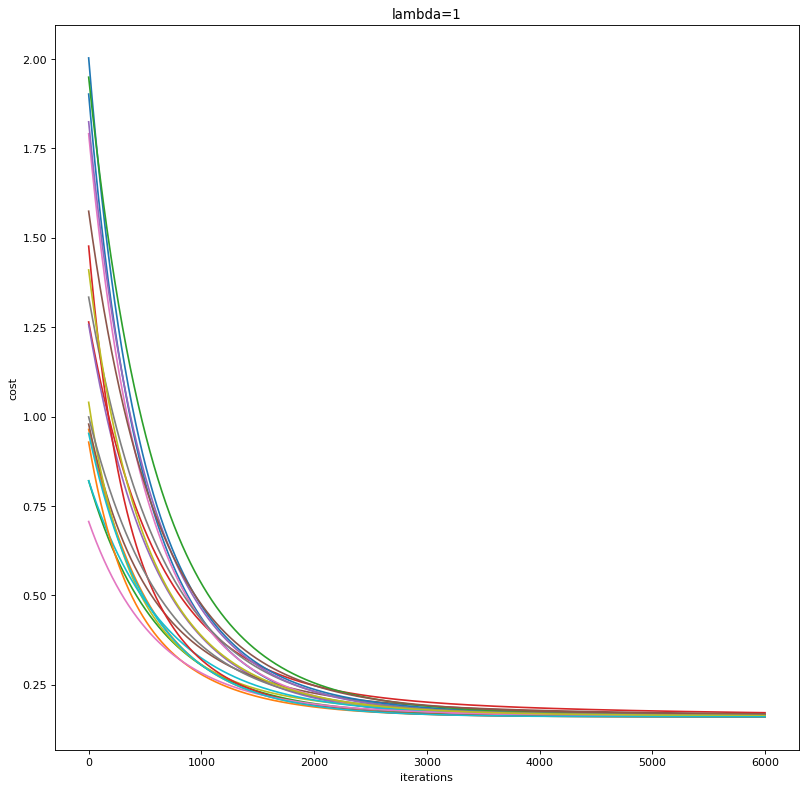

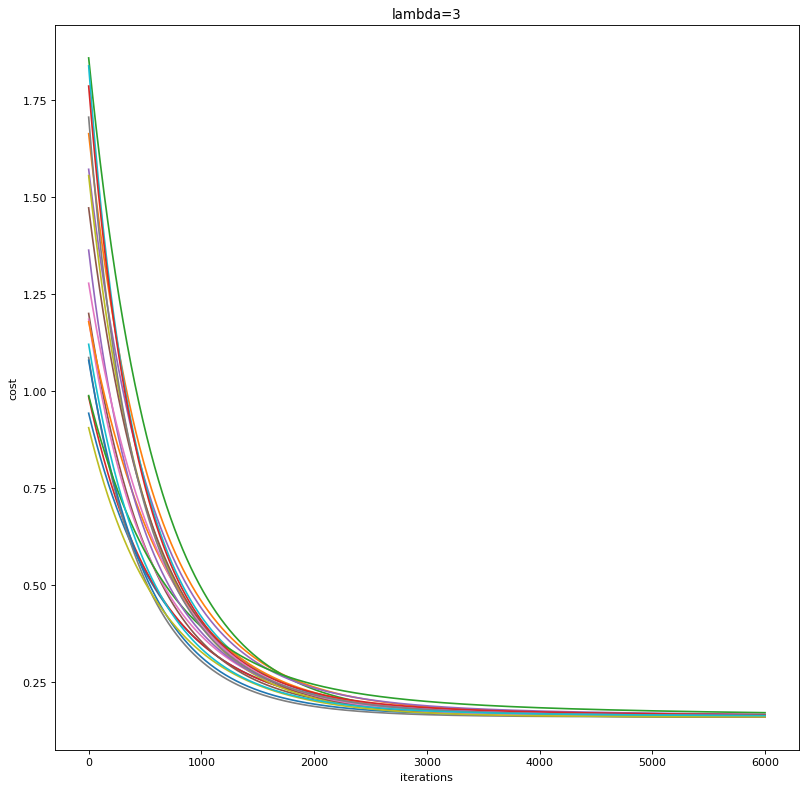

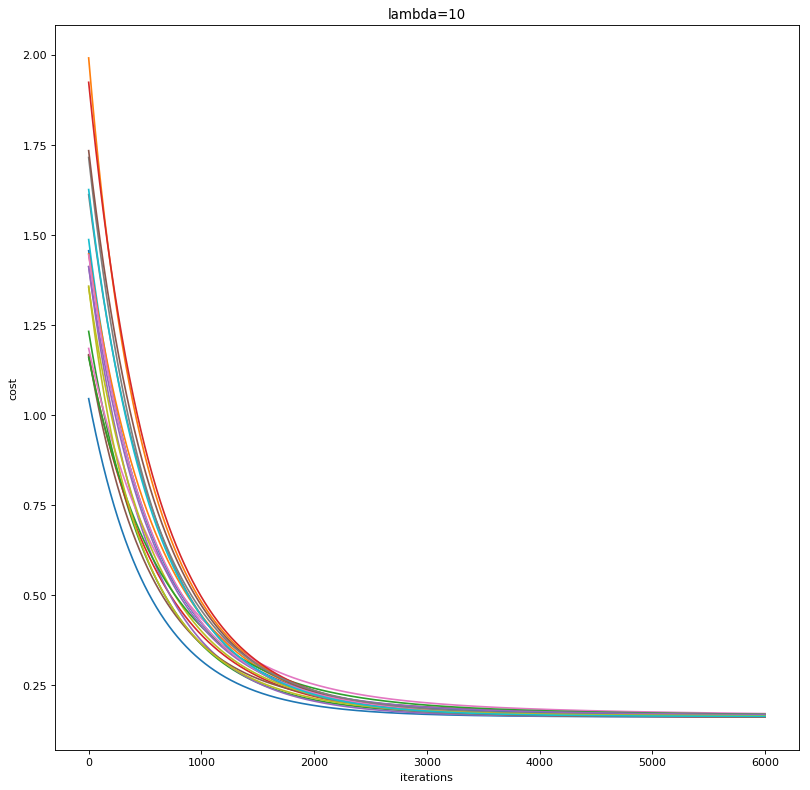

In [11]:
# Read data from text file
air_foil_data = pd.read_csv('./uci_airfoil_self_noise_dataset.csv')
print("Shape of data read: " + str(air_foil_data.shape))

# Preprocess the data
(x, y, col_names) = pre_process_data(air_foil_data)

M = x.shape[0]
N = x.shape[1]

# Normalize features
mew_x = []
std_x = []
for i in range(N):
    (mew_val, std_val, x[:,i]) = normalize(x[:,i])
    mew_x.append(mew_val)
    std_x.append(std_val)
(mew_y, std_y, y) = normalize(y)

# Add x0 to x
ones_vec = np.ones((M, 1), dtype=int)
x = np.hstack((ones_vec, x))

# Split the dataset
(train_x, dev_x, test_x, train_y, dev_y, test_y) = split_dataset(x, y, 70, 20, 10)

alpha = 0.001
num_iters = 6000

# regularization parameter lambda
possible_lambd = [0, 0.3, 1, 3, 10]

global_min_cost = sys.maxsize
global_optimal_theta = np.empty((N, 1))
final_lambd = 0

for lambd in possible_lambd:
    
    print("Running gradient descent for lambda=" + str(lambd) + " ...")
    
    # Optimize
    optimal_theta, min_cost = gradient_descent_optimize(train_x, dev_x, train_y, dev_y,
                                                        20, squared_error_cost, alpha, num_iters, lambd)
    
    if(min_cost < global_min_cost):
        global_min_cost = min_cost
        global_optimal_theta = optimal_theta
        final_lambd = lambd

# Results
print("\nNetwork parameters:")
print("alpha: " + str(alpha))
print("lambda: " + str(final_lambd))
print("num_iters: " + str(num_iters))
print("Optimal value of theta: \n" + str(global_optimal_theta))

print("\n")
print("Cost on train set: " + str(squared_error_cost(train_x, train_y, global_optimal_theta, final_lambd)))
rmse = predict(train_x, train_y, optimal_theta, mew_x, std_x, mew_y, std_y, col_names, False, None)
print("RMSE accuracy on train set: " + str(rmse))
print("\n")
print("Cost on dev set: " + str(squared_error_cost(dev_x, dev_y, global_optimal_theta, final_lambd)))
rmse = predict(dev_x, dev_y, optimal_theta, mew_x, std_x, mew_y, std_y, col_names, False, None)
print("RMSE accuracy on dev set: " + str(rmse))
print("\n")
print("Cost on test set: " + str(squared_error_cost(test_x, test_y, global_optimal_theta, final_lambd)))
rmse = predict(test_x, test_y, optimal_theta, mew_x, std_x, mew_y, std_y, col_names, True, 3)
print("RMSE accuracy on test set: " + str(rmse))